# Create Your Own Cognitive Portrait

Hello! Let's create some **Science Art** together with this **Cogntivie Portrait** challenge!

This is short notebook with mostly the code, you can view more detailed instructions in `CognitivePortrait.ipynb`.

In [27]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install --quiet azure-cognitiveservices-vision-face
import cv2
import matplotlib.pyplot as plt
import glob, os

Obtain the Face API Key in one of the following ways:

* Request 7 days trial key [here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&wt.mc_id=aiapril-github-dmitryso).
* If you have an Azure Subscription - [create Cognitive Services resource](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account/?wt.mc_id=aiapril-github-dmitryso), and grab key/url from there
* [Create free trial subscription](https://azure.microsoft.com/free/?wt.mc_id=aiapril-github-dmitryso) and follow previous step

**Important:** If you use trial key, your Face API will have some limitations, in terms of number of images you can process, and frequency of API calls (not more than 20 calls per minute). In order to make things work, we would need to insert some pauses in between calls, when using API on a series of images.

After you get the key and endpoint, please insert them into the cell below. There would typically be two keys given on the portal, you can use any one of them.

In [28]:
key = '--INSERT YOUR KEY HERE--'
endpoint = 'https://westus2.api.cognitive.microsoft.com' 
# You might need different endpoint, check the cognitive services page!

In [29]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

## Getting Some Images

In this repository, sample images of Bill Gates are available in  `images/gates` directory. You can upload your own images using Azure Notebooks file upload feature. I suggest you create some other directory inside `images` for that purpose. Specify the directory name in the variable below:

In [30]:
path = 'images/gates/*'

For our further experiments, let's load 13 first images, and run them through Face API to obtain facial landmarks. We will save the images into `images` array, and landmarks data into `imagepoints`.

In [32]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fnames = glob.glob(path)

filenames = []
images = []
imagepoints = []
cli.face.detect_with_url('https://soshnikov.com/images/official/shwars_geek.jpg')
for fn in fnames[0:13]:
    print("Processing {}".format(fn))
    with open(fn,'rb') as f:
        res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())

Processing images/gates\gates_0.jpg
Processing images/gates\gates_1.jpg
Processing images/gates\gates_10.jpg
Processing images/gates\gates_11.jpg
Processing images/gates\gates_12.jpg
Processing images/gates\gates_13.jpg
Processing images/gates\gates_14.jpg
Processing images/gates\gates_15.jpg
Processing images/gates\gates_16.jpg
Processing images/gates\gates_17.jpg
Processing images/gates\gates_19.jpg
Processing images/gates\gates_2.jpg
Processing images/gates\gates_21.jpg


In [33]:
print(imagepoints[0])

{'pupil_left': {'x': 530.2, 'y': 387.6}, 'pupil_right': {'x': 725.6, 'y': 410.9}, 'nose_tip': {'x': 637.9, 'y': 514.3}, 'mouth_left': {'x': 504.7, 'y': 593.0}, 'mouth_right': {'x': 689.4, 'y': 623.4}, 'eyebrow_left_outer': {'x': 454.0, 'y': 337.5}, 'eyebrow_left_inner': {'x': 604.4, 'y': 362.7}, 'eye_left_outer': {'x': 497.2, 'y': 385.8}, 'eye_left_top': {'x': 529.8, 'y': 381.0}, 'eye_left_bottom': {'x': 524.9, 'y': 397.7}, 'eye_left_inner': {'x': 558.2, 'y': 395.7}, 'eyebrow_right_inner': {'x': 670.2, 'y': 371.2}, 'eyebrow_right_outer': {'x': 785.7, 'y': 365.1}, 'eye_right_inner': {'x': 688.6, 'y': 410.4}, 'eye_right_top': {'x': 720.5, 'y': 403.0}, 'eye_right_bottom': {'x': 718.5, 'y': 421.4}, 'eye_right_outer': {'x': 750.4, 'y': 419.5}, 'nose_root_left': {'x': 601.6, 'y': 405.1}, 'nose_root_right': {'x': 650.6, 'y': 411.2}, 'nose_left_alar_top': {'x': 596.2, 'y': 473.7}, 'nose_right_alar_top': {'x': 666.6, 'y': 478.8}, 'nose_left_alar_out_tip': {'x': 558.2, 'y': 514.0}, 'nose_right_a

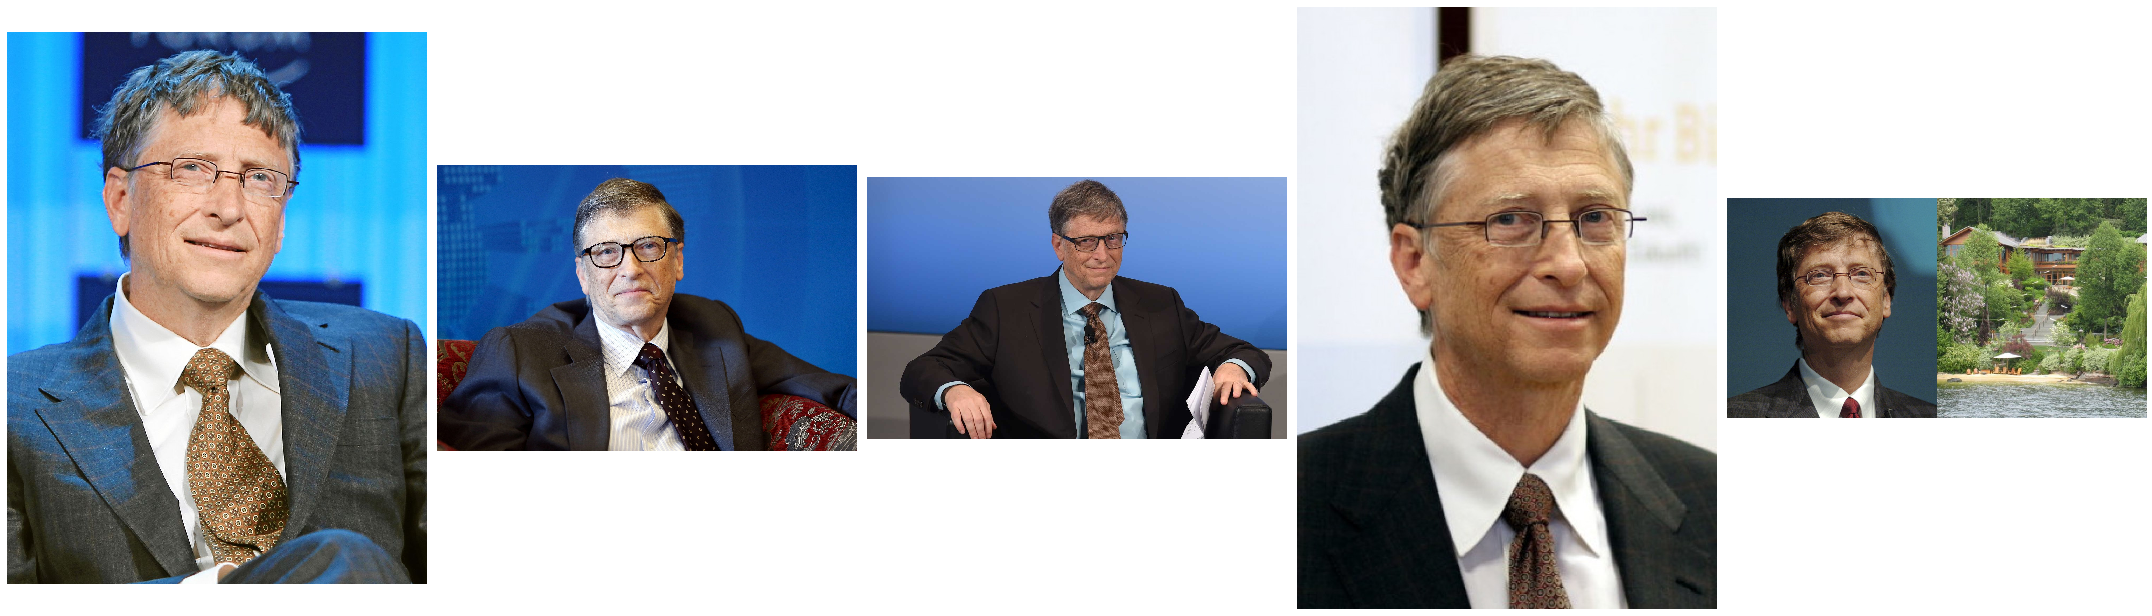

In [34]:
def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

display_images(images[:5])

## Affine Transformations

The function to rotate our images to the fixes eyes-mouth position can be defined as follows:

In [35]:
import numpy as np

target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))

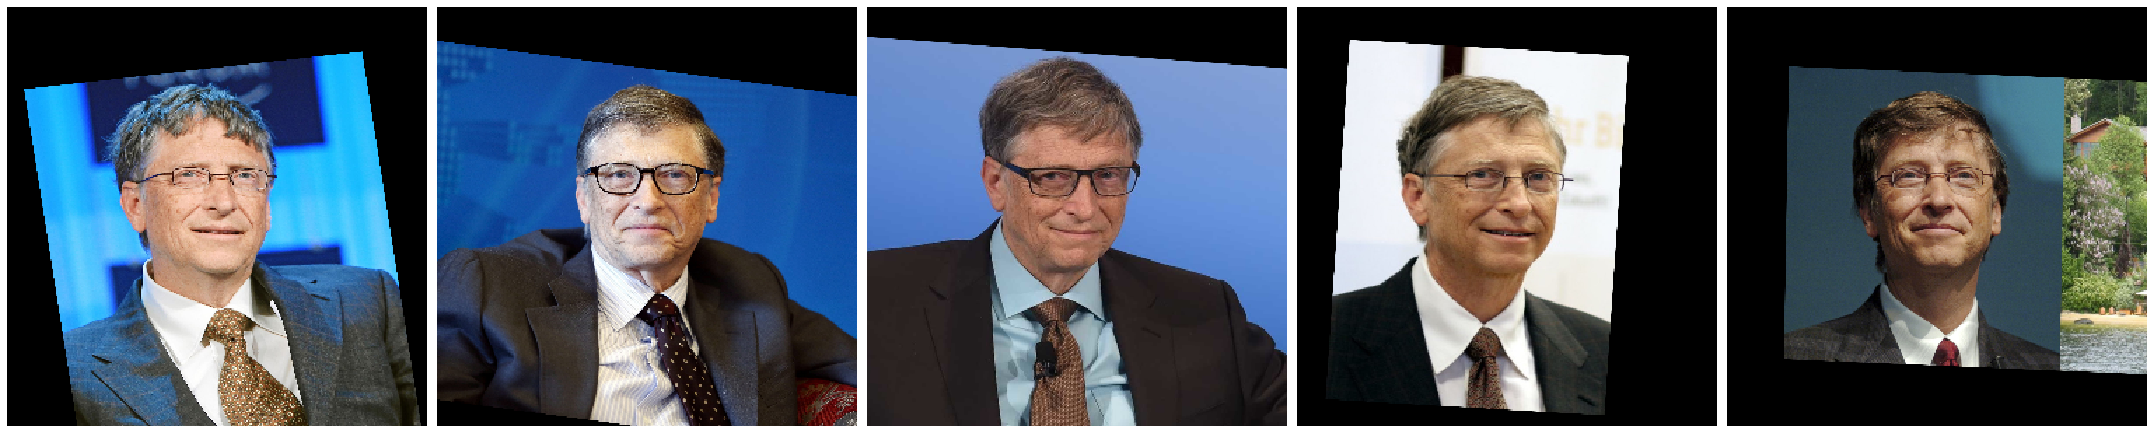

In [36]:
img_aligned = [affine_transform(i,a) for i,a in zip(images,imagepoints)]
display_images(img_aligned[:5])

## Image Blending

To blend images together, we just calculate the average:

In [37]:
def merge(imgs):
    return (np.average(np.array(imgs)/255.,axis=0)*255).astype(np.ubyte)

Now let's merge all aligned images altogether and see what happens:

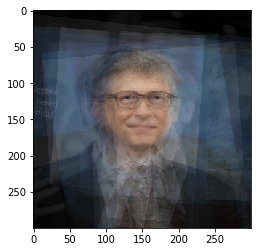

In [38]:
res = merge(img_aligned)
plt.imshow(res)

## Saving the result

I recommend to save the result into `results` directory, and to add quick description of the technique you used into `readme.md` file in the repo. To save the image, please execute the cell below:

In [31]:
cv2.imwrite('results/gates.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True